# The Two-Infall Star Formation Law

## Spitoni et al. (2024)

Spitoni reports that they use a Kennicutt (1998) law:

$$ \dot\Sigma_\star(t) \propto \nu_{\rm spec} \cdot \Sigma_g(t)^k $$

where $\nu_{\rm spec} = \nu_{\rm high,low}$ is the specified star formation efficiency (SFE), 
with timescale $\tau_{\rm\star,spec} = \nu_{\rm spec}^{-1}$, and $k=1.5$.
To determine the exact scaling of this relation, I re-write their SF law as

$$ \dot\Sigma_\star(t) = F \cdot \nu_{\rm spec} \cdot \Sigma_g(t)^k $$

with unknown scaling factor $F$. In their Figure 9, they show the evolution of gas, stellar, and SFR density with time:

![image.png](Spitoni2024_fig9.png)

Let's examine the star formation law at multiple epochs. First, at a lookback time of 12 Gyr ($t=0.5$ Gyr), we have 
$\dot\Sigma_\star \approx 10$ M$_\odot$ pc$^{-2}$ Gyr$^{-1}$ and $\Sigma_g \approx 6$ M$_\odot$ pc$^{-2}$,
so $\tau_\star\approx0.6$ Gyr.
During the first infall, they set $\nu_{\rm spec}=\nu_{\rm high}=2$ Gyr$^{-1}$. Therefore,

$$ 
F = \frac{\dot\Sigma_\star(t=0.5\,{\rm Gyr})}{\nu_{\rm spec} \cdot \Sigma_g(t=0.5\,{\rm Gyr})^{1.5}} 
  = \frac{10\,{\rm M}_\odot\,{\rm pc}^{-2}\,{\rm Gyr}^{-1}}{(2\,{\rm Gyr}^{-1})(6\,{\rm M}_\odot\,{\rm pc}^{-2})^{1.5}}
  \approx 0.34\,{\rm M}_\odot^{-1/2}\,{\rm pc}.
$$

Next, at the end of the first infall ($t=3.5$ Gyr, or a lookback time of 9 Gyr), we have
$\dot\Sigma_\star \approx 1$ M$_\odot$ pc$^{-2}$ Gyr$^{-1}$ and $\Sigma_g \approx 1$ M$_\odot$ pc$^{-2}$,
so $\tau_\star\approx 1$ Gyr. Therefore,

$$ 
F = \frac{\dot\Sigma_\star(t=3.5\,{\rm Gyr})}{\nu_{\rm spec} \cdot \Sigma_g(t=3.5\,{\rm Gyr})^{1.5}} 
  = \frac{1\,{\rm M}_\odot\,{\rm pc}^{-2}\,{\rm Gyr}^{-1}}{(2\,{\rm Gyr}^{-1})(1\,{\rm M}_\odot\,{\rm pc}^{-2})^{1.5}}
  = 0.5\,{\rm M}_\odot^{-1/2}\,{\rm pc}.
$$

Next, at the peak SFR of the second infall ($t=6.5$ Gyr, or a lookback time of 6 Gyr), we have
$\dot\Sigma_\star \approx 5$ M$_\odot$ pc$^{-2}$ Gyr$^{-1}$ and $\Sigma_g \approx 14$ M$_\odot$ pc$^{-2}$,
so $\tau_\star\approx 2.8$ Gyr. Therefore,

$$ 
F = \frac{\dot\Sigma_\star(t=6.5\,{\rm Gyr})}{\nu_{\rm spec} \cdot \Sigma_g(t=6.5\,{\rm Gyr})^{1.5}} 
  = \frac{5\,{\rm M}_\odot\,{\rm pc}^{-2}\,{\rm Gyr}^{-1}}{(1\,{\rm Gyr}^{-1})(14\,{\rm M}_\odot\,{\rm pc}^{-2})^{1.5}}
  \approx 0.095\,{\rm M}_\odot^{-1/2}\,{\rm pc}.
$$

Finally, at the end of the simulation ($t=12.5$ Gyr), we have
$\dot\Sigma_\star \approx 2$ M$_\odot$ pc$^{-2}$ Gyr$^{-1}$ and $\Sigma_g \approx 8$ M$_\odot$ pc$^{-2}$,
so $\tau_\star\approx 4$ Gyr. During the second infall, $\nu_{\rm spec}=\nu_{\rm low}=1$ Gyr$^{-1}$. Therefore,

$$ 
F = \frac{\dot\Sigma_\star(t=12.5\,{\rm Gyr})}{\nu_{\rm spec} \cdot \Sigma_g(t=12.5\,{\rm Gyr})^{1.5}} 
  = \frac{2\,{\rm M}_\odot\,{\rm pc}^{-2}\,{\rm Gyr}^{-1}}{(1\,{\rm Gyr}^{-1})(8\,{\rm M}_\odot\,{\rm pc}^{-2})^{1.5}}
  \approx 0.088\,{\rm M}_\odot^{-1/2}\,{\rm pc}.
$$

Within the margin of error of my estimates from the plot, the first and second values are roughly consistent with each other, as are the third and fourth.
But some aspect of the star formation law seems to change between the first and second infalls, which is not accounted for by the change in $\nu_{\rm spec}$.

### Weird coincidence?

The values of $\tau_\star$ that I calculated from the figure don't seem to line up very well with their stated SF law. However, they *do* seem rather similar to the molecular gas timescale.

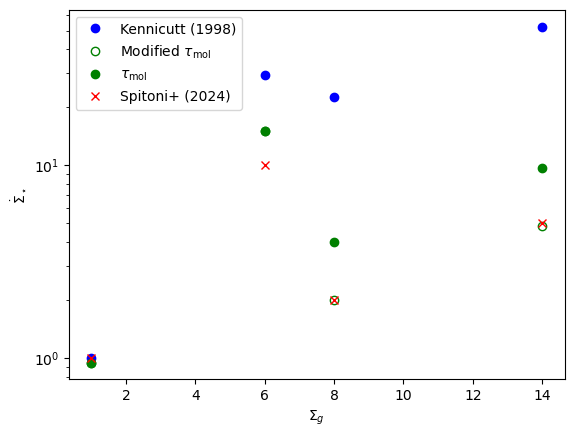

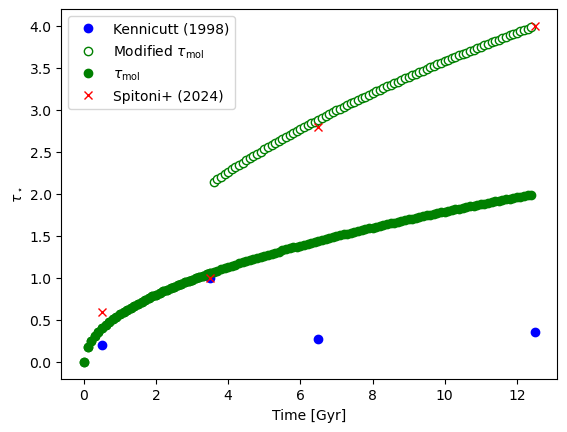

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def nu_spec(time, onset=3.52):
    if time < onset:
        return 2.
    else:
        return 1.

def tmol_factor(time, onset=3.52):
    if time < onset:
        return 1.
    else:
        return 2.

def kennicutt_schmidt(time, sigma_gas, onset=3.5, k=1.5):
    """Predict SFR surface density from Kennicutt (1998) relation"""
    return nu_spec(time, onset=onset) * sigma_gas**1.5

def molecular_timescale(time, tmol0=2, t0=12.5, exp=0.5):
    return tmol0 * (time / t0) ** exp

# "data" from Spitoni et al. (2024) fig 9
time_list = [0.5, 3.5, 6.5, 12.5]
sigma_gas_list = [6, 1, 14, 8]
sfr_list = [10, 1, 5, 2]
tau_star_list = [sigma_gas_list[i] / sfr_list[i] for i in range(len(time_list))]

fig, ax = plt.subplots()
ks_predict = [kennicutt_schmidt(time_list[i], sigma_gas_list[i]) for i in range(len(time_list))]
ax.plot(sigma_gas_list, ks_predict, 'bo', label='Kennicutt (1998)')
tmol_predict_mod = [sigma_gas_list[i] / (tmol_factor(time_list[i]) * molecular_timescale(time_list[i])) for i in range(len(time_list))]
ax.plot(sigma_gas_list, tmol_predict_mod, 'go', label=r'Modified $\tau_{\rm mol}$', markerfacecolor='w')
tmol_predict = [sigma_gas_list[i] / (molecular_timescale(time_list[i])) for i in range(len(time_list))]
ax.plot(sigma_gas_list, tmol_predict, 'go', label=r'$\tau_{\rm mol}$')
# plot data
ax.plot(sigma_gas_list, sfr_list, 'rx', label='Spitoni+ (2024)')
ax.set_xlabel(r'$\Sigma_g$')
ax.set_ylabel(r'$\dot\Sigma_\star$')
ax.set_yscale('log')
ax.legend()
plt.show()

fig, ax = plt.subplots()
tarr = np.arange(0, 12.5, 0.1)
ks_predict = [sigma_gas_list[i] / kennicutt_schmidt(time_list[i], sigma_gas_list[i]) for i in range(len(time_list))]
ax.plot(time_list, ks_predict, 'bo', label='Kennicutt (1998)')
tmol_predict_mod = [tmol_factor(t) * molecular_timescale(t) for t in tarr]
ax.plot(tarr, tmol_predict_mod, 'go', label=r'Modified $\tau_{\rm mol}$', markerfacecolor='w')
tmol_predict = [molecular_timescale(t) for t in tarr]
ax.plot(tarr, tmol_predict, 'go', label=r'$\tau_{\rm mol}$')
# plot data
ax.plot(time_list, tau_star_list, 'rx', label='Spitoni+ (2024)')
ax.set_ylabel(r'$\tau_\star$')
ax.set_xlabel('Time [Gyr]')
# ax.set_yscale('log')
ax.legend()
plt.show()

## Calculating $M_{\rm g,Schmidt}$

In VICE, the Schmidt-Kennicutt SF law is defined as follows:

$$ \tau_\star(t) = \tau_{\rm \star, spec}(t) \Big(\frac{M_g}{M_{\rm g,Schmidt}}\Big)^{-\alpha} $$

where $M_{\rm g,Schmidt}$ is the normalization of the ISM mass, and $\alpha=k-1$ converts from a gas density to a gas mass.
To convert the above equation into a format more similar to Spitoni et al. (2024), swap the masses for surface densities
and use $\tau_\star = \Sigma_g / \dot\Sigma_\star$:

\begin{align*}
    \dot\Sigma_\star &= \frac{\Sigma_g}{\tau_\star} \\
    &= \Sigma_g \nu_{\rm spec} \Big(\frac{\Sigma_g}{\Sigma_{\rm g,Schmidt}}\Big)^{k-1}
\end{align*}

where $\Sigma_{\rm g,Schmidt} = M_{\rm g,Schmidt}/A$ with area $A$. Then,

$$ \dot\Sigma_\star = \Sigma_{\rm g,Schmidt}^{1-k} \nu_{\rm spec} \Sigma_g^k  $$

which is the same form as in Spitoni et al. (2024). Therefore,

$$ F = \Sigma_{\rm g,Schmidt}^{1-k} = (M_{\rm g,Schmidt} / A)^{1-k}. $$

Rearranging the SF law gives

\begin{align*}
    \Sigma_{\rm g,Schmidt}^{1-k} &= \frac{\dot\Sigma_\star}{\nu_{\rm spec} \cdot \Sigma_g^k} \\
    \implies \Sigma_{\rm g,Schmidt} &= \Big(\frac{\dot\Sigma_\star}{\nu_{\rm spec} \cdot \Sigma_g^k}\Big)^{\frac{1}{1-k}} \\
    \implies M_{\rm g,Schmidt} &= A \cdot \Big(\frac{\dot\Sigma_\star}{\nu_{\rm spec} \cdot \Sigma_g^k}\Big)^{\frac{1}{1-k}} \\
    &= A \cdot F^{\frac{1}{1-k}} \\
    &= A \cdot F^{-1/\alpha}. \\
\end{align*}

Alternatively,

\begin{align*}
    \tau_\star(t) &= \tau_{\rm \star, spec}(t) \Big(\frac{M_g}{M_{\rm g,Schmidt}}\Big)^{-\alpha} \\
    \implies \frac{\tau_\star}{\tau_{\rm \star,spec}} &= \Big(\frac{M_g}{M_{\rm g,Schmidt}}\Big)^{-\alpha} \\
    \implies \Big(\frac{\tau_\star}{\tau_{\rm \star,spec}}\Big)^{-1/\alpha} &= \frac{M_g}{M_{\rm g,Schmidt}} \\
    \implies M_{\rm g,Schmidt} &= M_g \Big(\frac{\tau_\star}{\tau_{\rm \star,spec}}\Big)^{1/\alpha} \\
    &= M_g (\tau_\star \cdot \nu_{\rm spec})^{1/(k-1)} \\
    &= A \cdot \Sigma_g(t) (\tau_\star \cdot \nu_{\rm spec})^{1/(k-1)} \\
\end{align*}